Learned Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 7), (9, 8), (9, 9)]


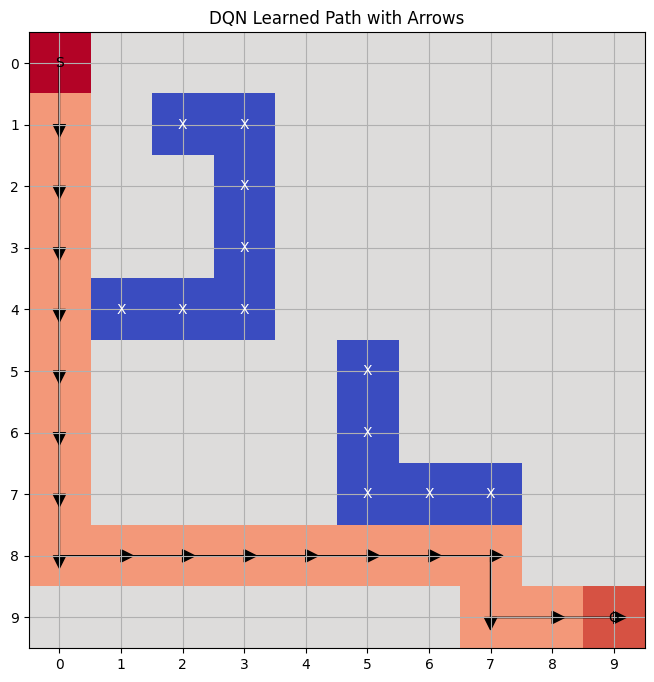

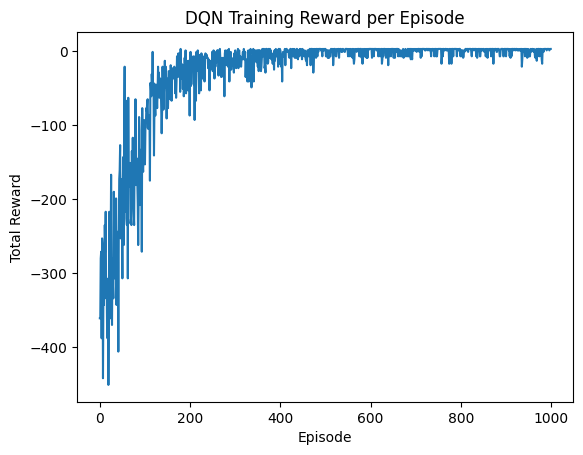

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

# ---- Grid setup ----
GRID_SIZE = 10
START = (0, 0)
GOAL = (9, 9)
OBSTACLES = {
    (1, 2), (1, 3), (2, 3), (3, 3),
    (4, 1), (4, 2), (4, 3), (5, 5),
    (6, 5), (7, 5), (7, 6), (7, 7)
}
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}

# ---- Model ----
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(GRID_SIZE * GRID_SIZE, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.net(x)

# ---- Utilities ----
def is_valid(pos):
    r, c = pos
    return 0 <= r < GRID_SIZE and 0 <= c < GRID_SIZE and pos not in OBSTACLES

def state_to_tensor(state, goal):
    grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.float32)
    grid[state] = 1.0
    grid[goal] = 0.5
    return torch.tensor(grid.flatten(), dtype=torch.float32).unsqueeze(0)

def choose_action(state_tensor, epsilon, model):
    if random.random() < epsilon:
        return random.choice(ACTIONS)
    with torch.no_grad():
        q_values = model(state_tensor)
    return ACTIONS[torch.argmax(q_values).item()]

# ---- Hyperparameters ----
gamma = 0.99
alpha = 0.001
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 0.995
EPISODES = 1000
MAX_STEPS = 100
TARGET_UPDATE_FREQ = 100
BATCH_SIZE = 32
MEMORY_SIZE = 5000

# ---- Initialize models ----
model = DQN()
target_model = DQN()
target_model.load_state_dict(model.state_dict())
target_model.eval()

optimizer = optim.Adam(model.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
memory = deque(maxlen=MEMORY_SIZE)

step_counter = 0
epsilon = epsilon_start
reward_per_episode = []

for episode in range(EPISODES):
    state = START
    total_reward = 0
    for step in range(MAX_STEPS):
        state_tensor = state_to_tensor(state, GOAL)
        action = choose_action(state_tensor, epsilon, model)
        next_state = (state[0] + action[0], state[1] + action[1])

        if not is_valid(next_state):
            next_state = state
            reward = -10
        elif next_state == GOAL:
            reward = 20
        else:
            reward = -1

        total_reward += reward
        done = (next_state == GOAL)

        memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(memory) >= BATCH_SIZE:
            batch = random.sample(memory, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            state_tensors = torch.cat([state_to_tensor(s, GOAL) for s in states])
            next_state_tensors = torch.cat([state_to_tensor(ns, GOAL) for ns in next_states])

            q_values = model(state_tensors)
            next_q_values = target_model(next_state_tensors)

            targets = q_values.clone().detach()
            for i in range(BATCH_SIZE):
                a_idx = ACTION_IDX[actions[i]]
                max_next_q = torch.max(next_q_values[i]).item()
                target_val = rewards[i] + gamma * max_next_q * (0 if dones[i] else 1)
                targets[i][a_idx] = target_val

            loss = loss_fn(q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        step_counter += 1
        if step_counter % TARGET_UPDATE_FREQ == 0:
            target_model.load_state_dict(model.state_dict())

        if done:
            break

    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    reward_per_episode.append(total_reward)

# ---- Path Extraction ----
def get_dqn_path(model, start, goal):
    path = [start]
    state = start
    for _ in range(MAX_STEPS):
        state_tensor = state_to_tensor(state, goal)
        with torch.no_grad():
            q_vals = model(state_tensor)
        best_action = ACTIONS[torch.argmax(q_vals).item()]
        next_state = (state[0] + best_action[0], state[1] + best_action[1])
        if not is_valid(next_state) or next_state in path:
            break
        path.append(next_state)
        if next_state == goal:
            break
        state = next_state
    return path

def visualize_path_with_arrows(path):
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for r, c in OBSTACLES:
        grid[r][c] = -1
    for r, c in path:
        grid[r][c] = 0.5
    grid[START] = 1
    grid[GOAL] = 0.8

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(grid, cmap='coolwarm', origin='upper')
    ax.set_title("DQN Learned Path with Arrows")

    for i in range(len(path) - 1):
        r1, c1 = path[i]
        r2, c2 = path[i + 1]
        ax.arrow(c1, r1, c2 - c1, r2 - r1, head_width=0.2, head_length=0.2, fc='black', ec='black')

    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            label = ""
            if (r, c) == START:
                label = "S"
            elif (r, c) == GOAL:
                label = "G"
            elif (r, c) in OBSTACLES:
                label = "X"
            ax.text(c, r, label, va='center', ha='center', color='white' if grid[r][c] < 0 else 'black')

    ax.set_xticks(np.arange(GRID_SIZE))
    ax.set_yticks(np.arange(GRID_SIZE))
    plt.grid(True)
    plt.show()

dqn_path = get_dqn_path(model, START, GOAL)
print("Learned Path:", dqn_path)
visualize_path_with_arrows(dqn_path)

plt.plot(reward_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Reward per Episode")
plt.show()